这章主要介绍循环神经网络的定义，原理及计算方法，并通过几个实例说明如何使用循环神经网络

15.2前向传播与随时间反向传播

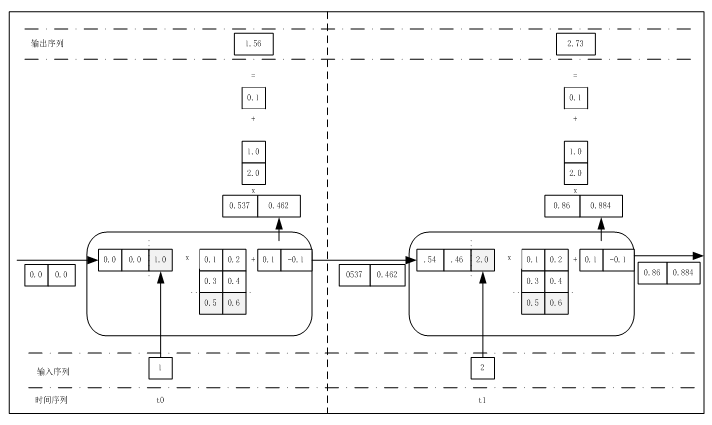

上图的计算过程，用Python程序实现的详细代码如下：

In [1]:
import numpy as np

X = [1,2]
state = [0.0, 0.0]
w_cell_state = np.asarray([[0.1, 0.2], [0.3, 0.4],[0.5, 0.6]])
b_cell = np.asarray([0.1, -0.1])
w_output = np.asarray([[1.0], [2.0]])
b_output = 0.1

for i in range(len(X)):
    state=np.append(state,X[i])
    before_activation = np.dot(state, w_cell_state) + b_cell
    state = np.tanh(before_activation)
    final_output = np.dot(state, w_output) + b_output
    print("状态值_%i: "%i, state)
    print("输出值_%i: "%i, final_output)


状态值_0:  [ 0.53704957  0.46211716]
输出值_0:  [ 1.56128388]
状态值_1:  [ 0.85973818  0.88366641]
输出值_1:  [ 2.72707101]


与标准的RNN网络一样，LSTM循环体结构也可以定义多层结构和网络结构。以下代码即完成了一个简单的LSTM网络结构的构建

In [ ]:

import tensorflow as tf

num_units = 128
num_layers = 2
batch_size = 100

#创建一个BasicLSTMCell，即LSTM循环体
#num_units为循环体中基本单元的个数，可以参考图15-4中标准RNN的num_units说明。数量越多，网络的特征表达能力也就越强，当然应该根据实际问题、结合经验以及实际实验结果，选择合适的num_units,避免过拟合。
rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units)

#使用多层结构，返回值仍然为cell结构
if num_layers>= 2:
    rnn_cell = tf.nn.rnn_cell.MultiRNNCell([rnn_cell]*num_layers)

#定义初始化状态
initial_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)

#定义输入数据结构已完成循环神经网络的构建。
outputs, state = tf.nn.dynamic_rnn(rnn_cell, input_data,
initial_state=initial_state, dtype=tf.float32)
# 'outputs'是一个张量，其形状为[batch_size, max_time, cell_state_size]
# 'state'是一个张量，其形状为[batch_size, cell_state_size]

15.7 实例：用LSTM实现分类

MINST数据集是一个非常典型的手写数字识别数据集，这里我们通过使用LSTM循环神经网络完成MINIST数据集的数字识别。MINIST数据集可以通过网站http://yann.lecnn.com/exdb/mnist下载到本地文件夹。 下载完成后，运行以下代码即可完成数据集的载入。或直接取第14章的数据。

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
#Tensorflow 中对MNIST数据集的处理作了封装，可以使用此对象更加方便地处理MNIST数据。
data_dir = './MNIST_data/' #下载数据文件的放置路径
mnist = input_data.read_data_sets(data_dir, one_hot=True)  
#接着，我们来看看这个数据集的大小。
print(mnist.train.images.shape)     
print(mnist.train.labels.shape)   
print(mnist.test.images.shape)     
print(mnist.test.labels.shape)


Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)
(10000, 784)
(10000, 10)


上面每一个图片（image）由784个像素点构成，是28*28（=784）的图片按行展开后拼接成的一维向量形式。以下代码对训练集中的第一张图片作了基本的可视化。

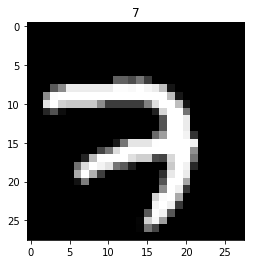

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(mnist.train.images[0].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(mnist.train.labels[0]))
plt.show()


对于循环神经网络，每个时刻读取图片中的一行，即每个时刻需要读取的数据向量长度为28，读完整张图片需要读取28行。以下代码完成了循环神经网络的构建

In [7]:
TIME_STEP = 28  #一张图片需要读取28行
INPUT_SIZE = 28 #每次读取的向量长度，即每行由28个像素点构成。

#定义输入、输出placeholder
tf_x = tf.placeholder(tf.float32, [None, TIME_STEP * INPUT_SIZE])      
image = tf.reshape(tf_x, [-1, TIME_STEP, INPUT_SIZE])                   
tf_y = tf.placeholder(tf.int32, [None, 10])                             

# 定义LSTM结构
rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units=64)

#构建网络
outputs, (h_c, h_n) = tf.nn.dynamic_rnn(
    rnn_cell,                   # LSTM cell
    image,                      # 输入图片
    initial_state=None,         #隐藏层的初始化状态
    dtype=tf.float32,           # 如果initial_state = None，dtype必须给定
    time_major=False,           # TIME_STEP是否在输入数据的第一个纬度
)

# 取最后一个时刻的输出为作为读完每张图片后的最终输出
output = tf.layers.dense(outputs[:, -1,:], 10)   

#另外，在tensorflow中可以方便的定义代价函数和训练过程，
LR = 0.01 #定义学习率 Learning Rate
loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output) #使用交叉熵损失

#定义训练过程
train_op = tf.train.AdamOptimizer(LR).minimize(loss)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



通过此例我们还可以看到，循环神经网络里的时间不必是字面上现实世界中流逝的时间。在此例中，它仅表示序列中的位置，这在实际应用中也很常见。下面给出MNIST手写数字识别的完整代码。

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)


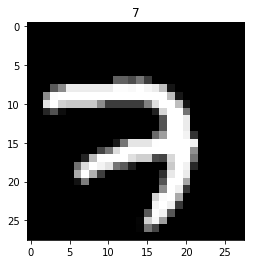

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(1)
np.random.seed(1)

# 定义超参数
BATCH_SIZE = 64
TIME_STEP = 28          # RNN的时间步，这里用来表示图片段的高度
INPUT_SIZE = 28         # RNN的输入长度，这里用来表示图片的宽度
LR = 0.01               # 定义学习率（learning rate）

# 读入数据
mnist = input_data.read_data_sets('./MNIST_data/', one_hot=True)
test_x = mnist.test.images[:2000]
test_y = mnist.test.labels[:2000]

# 为了便于理解，画出一张图片观察一下
print(mnist.train.images.shape)     # (55000, 28 * 28)
print(mnist.train.labels.shape)   # (55000, 10)
plt.imshow(mnist.train.images[0].reshape((28, 28)), cmap='gray')
plt.title('%i' % np.argmax(mnist.train.labels[0]))
plt.show()


In [2]:
# 定义表示x向量的tensorflow placeholders
tf_x = tf.placeholder(tf.float32, [None, TIME_STEP * INPUT_SIZE])       # 形状为(batch, 784)
image = tf.reshape(tf_x, [-1, TIME_STEP, INPUT_SIZE])   
# 定义表示y向量的placehoder
tf_y = tf.placeholder(tf.int32, [None, 10])                            
# RNN的循环体结构，使用LSTM
rnn_cell = tf.contrib.rnn.BasicLSTMCell(num_units=64)
outputs, (h_c, h_n) = tf.nn.dynamic_rnn(
    cell=rnn_cell,                   # 使用选定的cell
    inputs=image,                      # 输入数据，这里是图片
    initial_state=None,         # 隐藏层的初始状态
    dtype=tf.float32,           #如果initial_state = None，dtype必须给定
    time_major=False,           # TIME_STEP是否在输入数据的第一个纬度，这里，False: (batch, time step, input); True: (time step, batch, input)
)


In [10]:
# 使用最后一个时间步的输出作为最终输出结果
output = tf.layers.dense(outputs[:, -1, :], 10)              
# 计算损失函数
#loss = tf.losses.softmax_cross_entropy(onehot_labels=tf_y, logits=output)   
loss=tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_y, logits=output)   

train_op = tf.train.AdamOptimizer(LR).minimize(loss)

# 计算预测精度
accuracy = tf.metrics.accuracy(labels=tf.argmax(tf_y, axis=1), predictions=tf.argmax(output, axis=1),)[1]

sess = tf.Session()
# 初始化精度计算中所需要的变量
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()) 
# 初始化计算图中的变量
sess.run(init_op)     

# 开始执行训练
for step in range(1400):    
    b_x, b_y = mnist.train.next_batch(BATCH_SIZE)
    _, loss_ = sess.run([train_op, loss], {tf_x: b_x, tf_y: b_y})
    if step % 50 == 0:      # 计算精度
        accuracy_ = sess.run(accuracy, {tf_x: test_x, tf_y: test_y})
        print('test accuracy: %.2f' % accuracy_)
      

# 输出测试集中的十个预测结果
test_output = sess.run(output, {tf_x: test_x[:10]})
pred_y = np.argmax(test_output, 1)
print(pred_y, 'prediction number')
print(np.argmax(test_y[:10], 1), 'real number')


test accuracy: 0.12
test accuracy: 0.38
test accuracy: 0.51
test accuracy: 0.59
test accuracy: 0.65
test accuracy: 0.69
test accuracy: 0.73
test accuracy: 0.75
test accuracy: 0.77
test accuracy: 0.79
test accuracy: 0.80
test accuracy: 0.81
test accuracy: 0.83
test accuracy: 0.83
test accuracy: 0.84
test accuracy: 0.85
test accuracy: 0.85
test accuracy: 0.86
test accuracy: 0.86
test accuracy: 0.87
test accuracy: 0.87
test accuracy: 0.88
test accuracy: 0.88
test accuracy: 0.88
test accuracy: 0.89
test accuracy: 0.89
test accuracy: 0.89
test accuracy: 0.90
[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
